# Effect of the Visit Loss

In [1]:
import tensorflow as tf
import tools.mnist as mnist_tools
import tools.semisup as semisup
import numpy as np
import architectures as arch

import tools.visualization as vis
import tools.updated_semisup as up

%load_ext autoreload
%autoreload 2

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
train_images, train_labels = mnist_tools.get_data('train')
test_images, test_labels = mnist_tools.get_data('train')

Extracting /home/frankzl/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/frankzl/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/train-labels-idx1-ubyte.gz


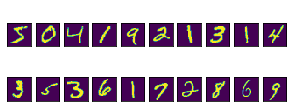

In [3]:
vis.imshow(train_images[:20], num_row=10, hspace=0, figsize=(5,2))

In [5]:
# labeled samples used per class
sup_per_class = 10
sup_seed = -1
# labeled samples per class per batch
sup_per_batch = 10
unsup_batch_size = 100


learning_rate = 1e-3
decay_steps = 5000
decay_factor = 0.33
visit_weight = 1.0

max_steps = 2000
eval_interval = 500

log_dir = "logs/visit-1"

seed = None

NUM_LABELS = mnist_tools.NUM_LABELS
IMAGE_SHAPE = mnist_tools.IMAGE_SHAPE

# gets sup_per_class samples for each class

# [10 (classes), 10 (samples), 28, 28, 1]

sup_by_label = semisup.sample_by_label(train_images, train_labels,
                        sup_per_class, NUM_LABELS, seed)

In [7]:
from ipywidgets import IntProgress, Layout

graph = tf.Graph()


with graph.as_default():
    
    model = semisup.SemisupModel(arch.mnist_model, NUM_LABELS, IMAGE_SHAPE)
    
    # iterator = up.create_input(train_images, train_labels, unsup_batch_size)
    # t_unsup_images, _ = up.create_input(train_images, train_labels, unsup_batch_size)
    
    #it = up.create_input(train_images, train_labels, unsup_batch_size)
    #t_unsup_images,_ = it.get_next()
    
    unsup_data = up.create_input(train_images, train_labels, unsup_batch_size)
    unsup_it   = unsup_data.make_initializable_iterator()
    
    t_unsup_images,_ = unsup_it.get_next()
    
    
    sup_data = up.create_per_class_inputs(sup_by_label, sup_per_batch)
    sup_it   = sup_data.make_one_shot_iterator()
    
    item       = sup_it.get_next()
    temp_unzip = (list(zip(*item)))
    t_sup_images, t_sup_labels = tf.concat(temp_unzip[0], 0), tf.concat(temp_unzip[1], 0)
    
    #t_sup_images, t_sup_labels = up.create_per_class_inputs(sup_by_label, sup_per_batch)
    
    t_sup_emb   = model.image_to_embedding(t_sup_images)
    t_unsup_emb = model.image_to_embedding(t_unsup_images)
    
    t_sup_logit = model.embedding_to_logit(t_sup_emb)
    
    model.add_semisup_loss(t_sup_emb, t_unsup_emb, t_sup_labels, visit_weight=visit_weight)
    model.add_logit_loss(t_sup_logit, t_sup_labels)
    
    t_learning_rate = tf.train.exponential_decay(
        learning_rate,
        model.step,
        decay_steps,
        decay_factor,
        staircase = True
    )
    
    train_op = model.create_train_op(t_learning_rate)
    summary_op = tf.summary.merge_all()
    
    summary_writer = tf.summary.FileWriter(log_dir, graph)
    
    saver = tf.train.Saver()

---------
Variables: name (type shape) [size]
---------
net/conv1_1/weights:0 (float32_ref 3x3x1x32) [288, bytes: 1152]
net/conv1_1/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_2/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_2/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv2_1/weights:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
net/conv2_1/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_2/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv3_1/weights:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
net/conv3_1/biases:0 (float32_ref 128) [128, bytes: 512]
net/conv3_2/weights:0 (float32_ref 3x3x128x128) [147456, bytes: 589824]
net/conv3_2/biases:0 (float32_ref 128) [128, bytes: 512]
net/fc1/weights:0 (float32_ref 1152x128) [147456, bytes: 589824]
net/fc1/biases:0 (float32_ref 128) [128, bytes: 512]
net/fully_connected/weights:0 (float32_ref 128x10) [1280, bytes: 5120]
net/fully_c

In [9]:
from IPython.display import display

f = IntProgress(min=0, max=max_steps, layout= Layout(width="90%")) # instantiate the bar
display(f) # display the bar

with tf.Session(graph=graph) as sess:
    sess.run(unsup_it.initializer)
    sess.run(tf.global_variables_initializer())
    
    epoch = 1
    
    for step in range(max_steps):
        try:
            _, summaries = sess.run([train_op, summary_op])
        except tf.errors.OutOfRangeError:
            sess.run(unsup_it.initializer)
            epoch += 1
            _, summaries = sess.run([train_op, summary_op])
            
        f.value = step
        f.description = f"Ep{epoch}:{step}/{max_steps}"
        if (step + 1) % eval_interval == 0 or step == 99:
            print('Step: %d' % step)
            test_pred = model.classify(test_images).argmax(-1)
            conf_mtx = semisup.confusion_matrix(test_labels, test_pred, NUM_LABELS)
            test_err = (test_labels != test_pred).mean() * 100
            print(conf_mtx)
            print('Test error: %.2f %%' % test_err)
            print()
    
            test_summary = tf.Summary(
                value=[tf.Summary.Value(
                    tag='Test Err', simple_value=test_err)])
    
            summary_writer.add_summary(summaries, step)
            summary_writer.add_summary(test_summary, step)

            print(f"saving model - step {step}")
            saver.save(sess, log_dir, global_step=model.step)

IntProgress(value=0, layout=Layout(width='90%'), max=2000)

Step: 99
[[5818    5    1    2    9    1   28    0   52    7]
 [   1 6584   11   75   11    1   24   10   16    9]
 [  63  124 4813  308  212    0   54  141  181   62]
 [  32   16   34 5794    8   69   10   33   75   60]
 [  26   20    1    2 5246    0   53    9   56  429]
 [  31   64    1  109   49 4794  145    1   67  160]
 [ 111   45    0    0   99   29 5624    0    7    3]
 [  33   35   41   45  175    0    0 5597   24  315]
 [  83  123   10   86   31   18   69    6 5258  167]
 [  80   20    4   48   38    6    3  135   66 5549]]
Test error: 8.21 %

saving model - step <tf.Variable 'global_step:0' shape=() dtype=int64_ref>
Step: 499
[[5835    8    4    2    4    6   34    2   22    6]
 [   1 6638   46   17   16    0   12    9    1    2]
 [   7   19 5707   35   77    0   11   64   32    6]
 [   2   10   54 5966    2   34    1   26   16   20]
 [  15   15    6    0 5687    0   35   11    4   69]
 [   3   20    1   27   11 5290   38    2    9   20]
 [  24   32    1    1   16   45 5788 

In [8]:

train_step = 2000
model_checkpoint = f"{log_dir}-{train_step}"

with tf.Session(graph=graph) as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, model_checkpoint)
    
    sess.run(unsup_it.initializer)
    labels_, embedded_sup = sess.run([t_sup_labels, t_sup_emb])
    embedded_unsup = sess.run(t_unsup_emb)

INFO:tensorflow:Restoring parameters from logs/visit-1-2000


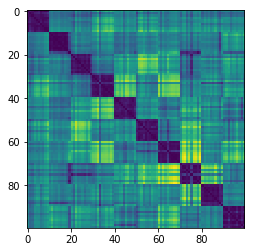

In [12]:
import tools.analyzer as ana
from tools.analyzer import Distance

similarity = ana.get_pairwise_distance(
    embedded_sup, 
    Distance.l2
)
import matplotlib.pyplot as plt
plt.imshow(similarity)

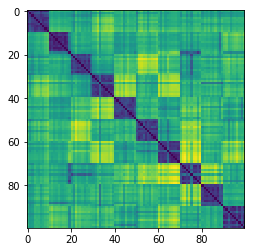

In [13]:
import tools.analyzer as ana
from tools.analyzer import Distance
similarity = ana.get_pairwise_distance(
    embedded_sup, 
    Distance.l1
)

plt.imshow(similarity)

INFO:tensorflow:Restoring parameters from logs/visit-1-100
INFO:tensorflow:Restoring parameters from logs/visit-1-500
INFO:tensorflow:Restoring parameters from logs/visit-1-1000
INFO:tensorflow:Restoring parameters from logs/visit-1-2000


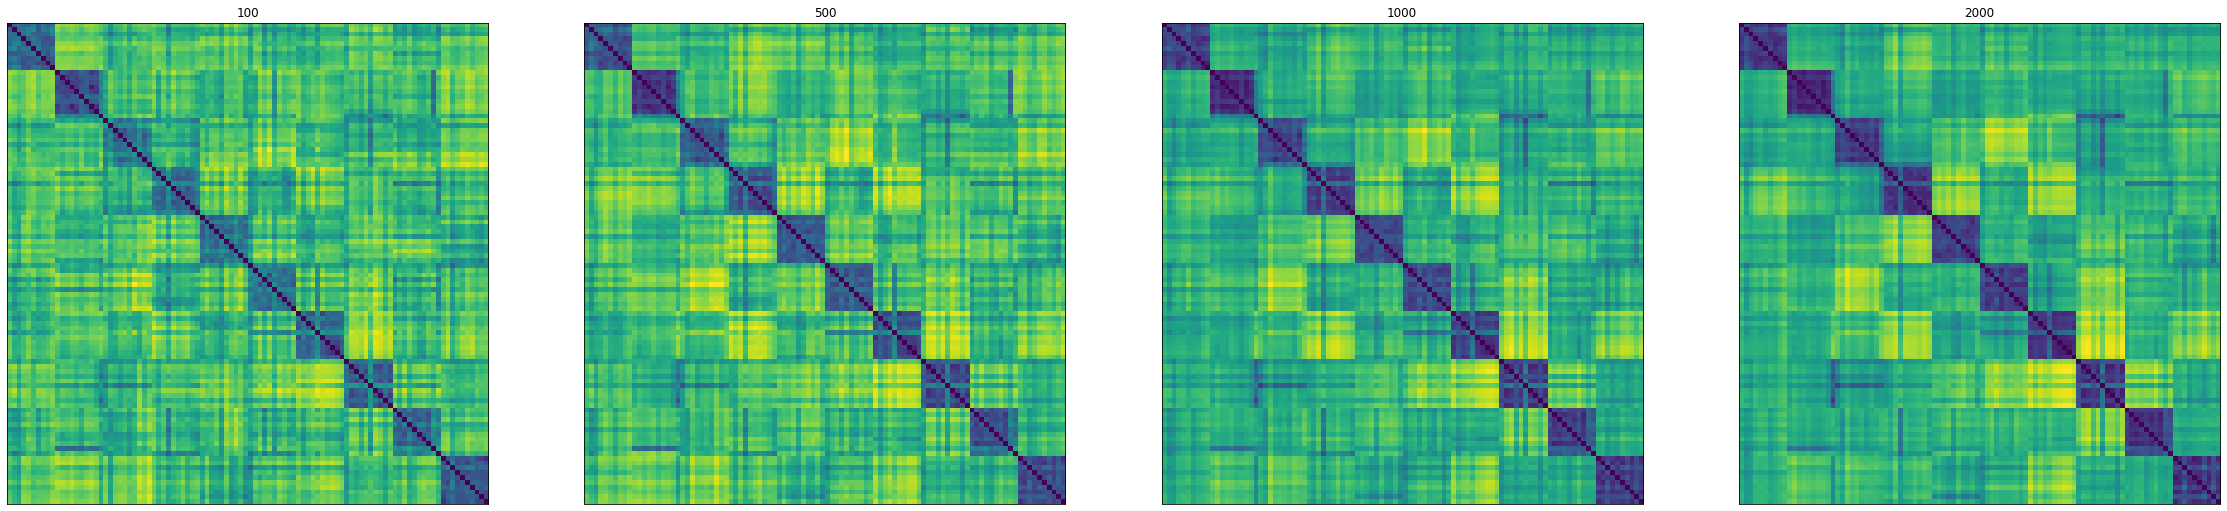

In [15]:
#f"{log_dir}-{train_step}"

def get_similarity(train_step, model_checkpoint, dist_func):
    
    with tf.Session(graph=graph) as sess:
        
        saver = tf.train.Saver()
        saver.restore(sess, model_checkpoint + str(train_step))
        
        sess.run(unsup_it.initializer)
        labels_, embedded_sup = sess.run([t_sup_labels, t_sup_emb])
        embedded_unsup = sess.run(t_unsup_emb)
        
    similarity = ana.get_pairwise_distance(
        embedded_sup, 
        dist_func
    )
    return similarity
    
dist_func = Distance.l1
similarities = []
labels = []
similarities.append(get_similarity(100, "logs/visit-1-", dist_func))
labels.append(100)
similarities.append(get_similarity(500, "logs/visit-1-", dist_func))
labels.append(500)
similarities.append(get_similarity(1000, "logs/visit-1-", dist_func))
labels.append(1000)
similarities.append(get_similarity(2000, "logs/visit-1-", dist_func))
labels.append(2000)

vis.imshow(similarities, figsize=(50,50), labels=labels, imgwidth=100)

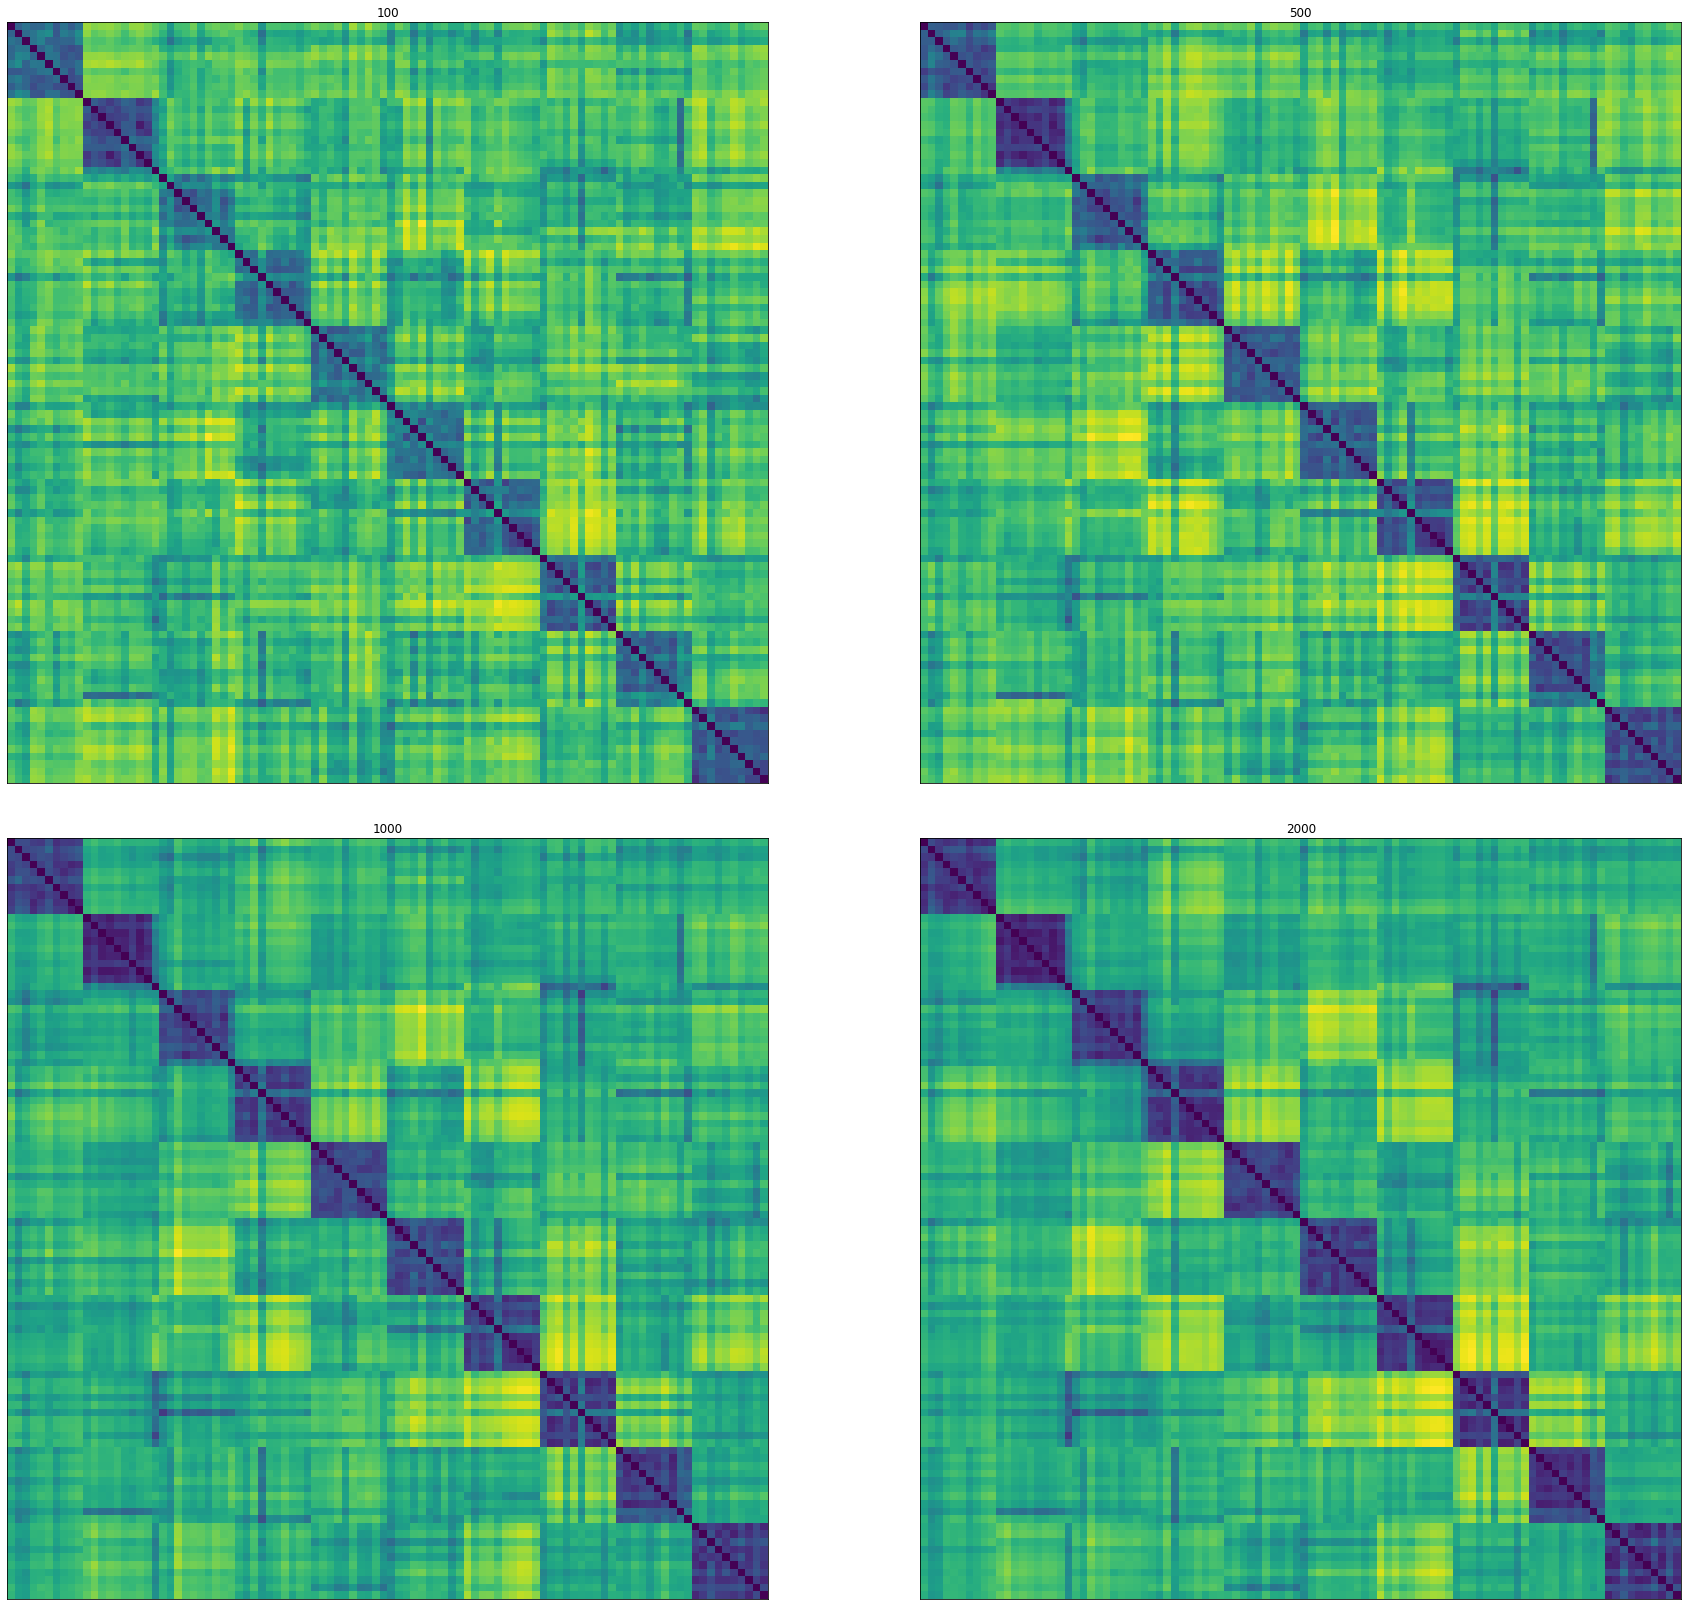

In [16]:
vis.imshow(similarities, figsize=(30,30), num_row=2,hspace=0, labels=labels, imgwidth=100)

In [30]:
def get_embedded(train_step, model_checkpoint):
    with tf.Session(graph=graph) as sess:
        
        saver = tf.train.Saver()
        saver.restore(sess, model_checkpoint + str(train_step))
        
        sess.run(unsup_it.initializer)
        labels_, embedded_sup = sess.run([t_sup_labels, t_sup_emb])
        embedded_unsup = sess.run(t_unsup_emb)
    
    stacked = np.vstack((embedded_sup, embedded_sup))
        
    return stacked

def get_similarity(stacked, dist_func):
    
    similarity = ana.get_pairwise_distance(
        stacked, 
        dist_func
    )
    return similarity

def retrieve_similarity(train_step, model_checkpoint, dist_func):
    stacked = get_embedded(train_step, model_checkpoint)   
    return get_similarity(stacked, dist_func)
    
dist_func = Distance.l1
similarities = []
labels = []
similarities.append(retrieve_similarity(100, "logs/visit-1-", dist_func))
labels.append(100)
similarities.append(retrieve_similarity(500, "logs/visit-1-", dist_func))
labels.append(500)
similarities.append(retrieve_similarity(1000, "logs/visit-1-", dist_func))
labels.append(1000)
similarities.append(retrieve_similarity(2000, "logs/visit-1-", dist_func))
labels.append(2000)

INFO:tensorflow:Restoring parameters from logs/visit-1-100
INFO:tensorflow:Restoring parameters from logs/visit-1-500
INFO:tensorflow:Restoring parameters from logs/visit-1-1000
INFO:tensorflow:Restoring parameters from logs/visit-1-2000


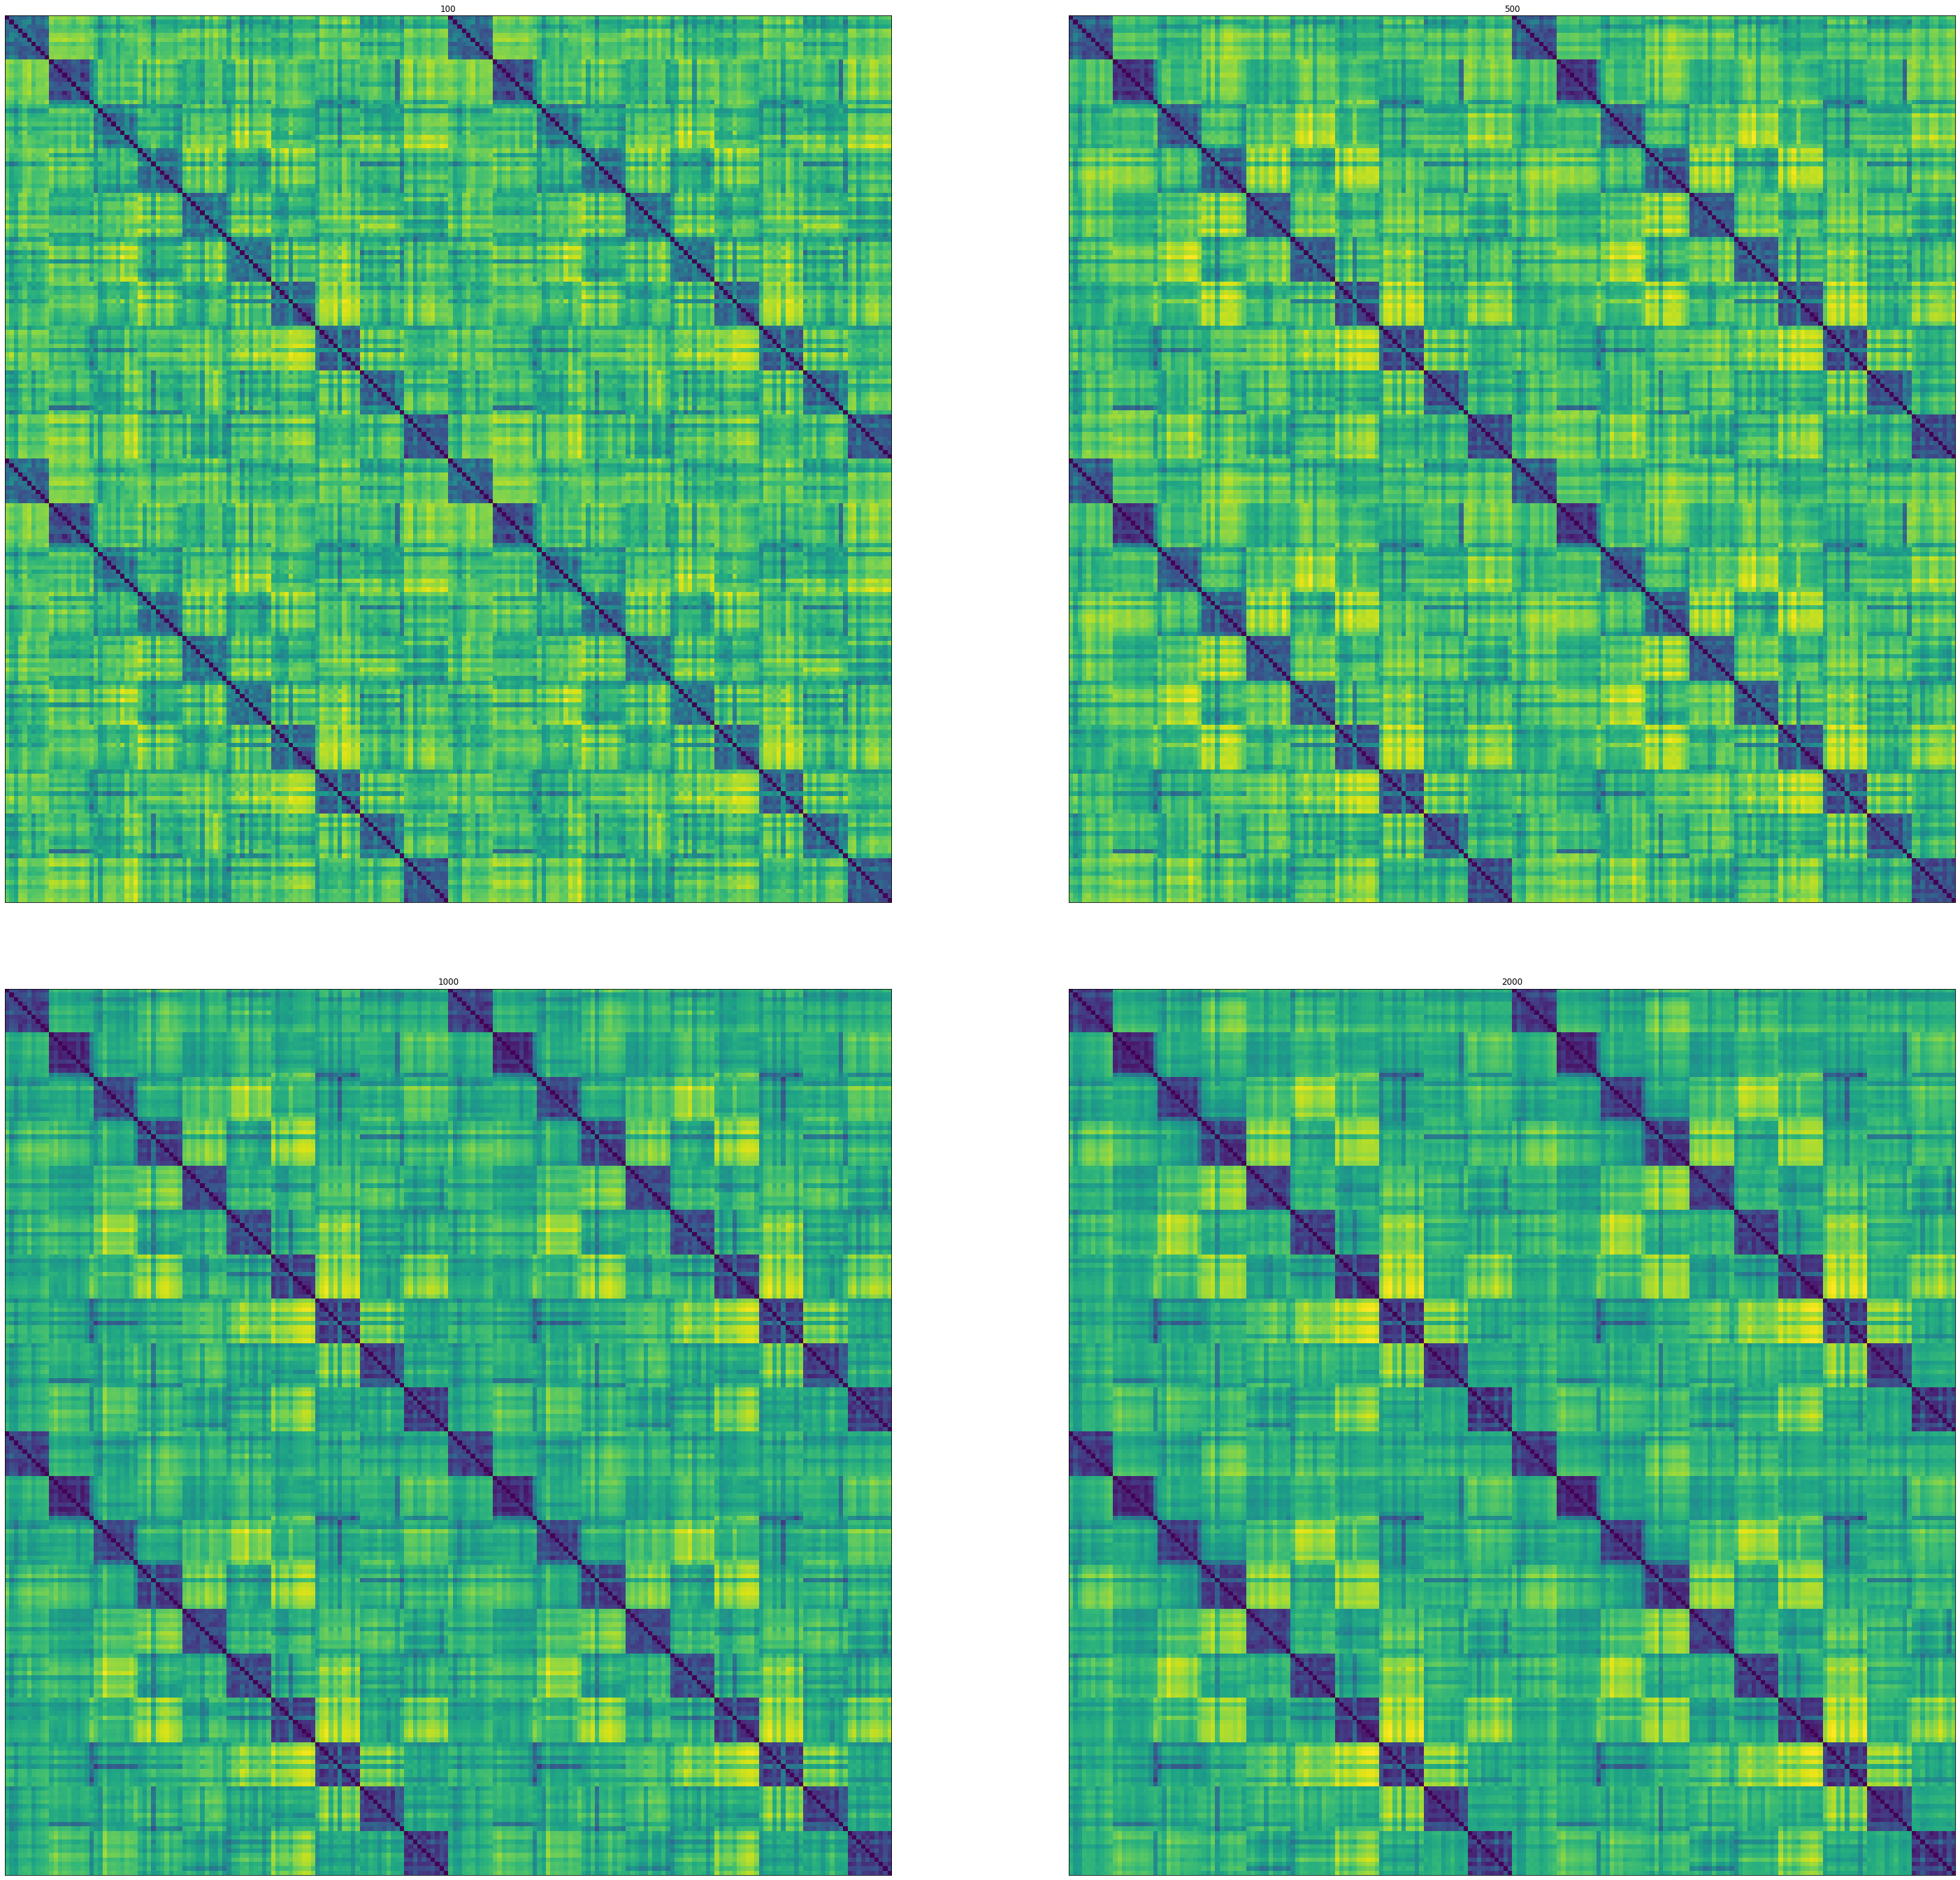

In [31]:
vis.imshow(similarities, figsize=(50,50), num_row=2,hspace=0.05, labels=labels, imgwidth=200)

In [37]:
from ipywidgets import FloatSlider
from IPython.html.widgets import *

stacked100 = get_embedded(100, "logs/visit-1-")
stacked2000 = get_embedded(2000, "logs/visit-1-")

interact(
    lambda sigma: vis.imshow(
        [
            get_similarity(stacked100, Distance.get_gaussian_k(sigma)),
            get_similarity(stacked2000, Distance.get_gaussian_k(sigma)),
        ], figsize=(50,50), hspace=0.05, labels=[100,2000], imgwidth=200
    ),
    sigma = FloatSlider(
        value=1,
        min=0.5,
        max=10.0,
        step=0.1,
        description='Effect of Gaussian Kernel',
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    )
)
interact(
    lambda sigma: plt.imshow(get_similarity(stacked2000, Distance.get_gaussian_k(sigma))),
    sigma = FloatSlider(
        value=1,
        min=0.5,
        max=10.0,
        step=0.1,
        description='Effect of Gaussian Kernel',
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    )
)

INFO:tensorflow:Restoring parameters from logs/visit-1-100
INFO:tensorflow:Restoring parameters from logs/visit-1-2000


interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Effect of Gaussian Kernel',…

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Effect of Gaussian Kernel',…

<function __main__.<lambda>(sigma)>